<a href="https://colab.research.google.com/github/Seonghoon-Yu/PyTorch_study/blob/main/ch03/ch03_Multi_Class_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('cookbook')

Mounted at cookbook


# 데이터 불러오기와 전처리
 데이터는 torchvision에서 제공하는 STL-10 dataset을 사용합니다.

In [2]:
# loading training data
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = '/data'

# if not exists the path, make the path
if not os.path.exists(path2data):
    os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)

print(train_ds.data.shape)

Extracting /data/stl10_binary.tar.gz to /data
(5000, 3, 96, 96)


In [3]:
# count the number of images per category in train_ds
import collections
y_train = [y for _,y in train_ds]
counter_train = collections.Counter(y_train)
print(counter_train)

Counter({1: 500, 5: 500, 6: 500, 3: 500, 9: 500, 7: 500, 4: 500, 8: 500, 0: 500, 2: 500})


In [4]:
# load test dataset and call it test0_ds
test0_ds = datasets.STL10(path2data, split='test', download=True, transform=data_transformer)
print(test0_ds.data.shape)

Files already downloaded and verified
(8000, 3, 96, 96)


In [5]:
# split the indices of test0_ds into two groups
# there aren't validation data in STL10 dataset, so make validation data
from sklearn.model_selection import StratifiedShuffleSplit

# StratifiedShuffleSplit sample the data in same proportion of labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test0_ds)))
y_test0 = [y for _,y in test0_ds]

for test_index, val_index in sss.split(indices, y_test0):
    print('test:', test_index, 'val:', val_index)
    print(len(val_index), len(test_index))

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400


In [6]:
# create two datasets from test0_ds
from torch.utils.data import Subset

# if test0_ds is updated, val_ds and test_ds are updated.
# because val_ds and test_ds are a subset of train_ds
val_ds = Subset(test0_ds, val_index)
test_ds = Subset(test0_ds, test_index)

In [7]:
# count the number of images per class in val_ds and test_ds
import collections
import numpy as np

y_test = [y for _, y in test_ds]
y_val = [y for _, y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)
print(counter_test)
print(counter_val)

Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})
Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})


image indices: [2732 2607 1653 3264]
torch.Size([3, 98, 389])


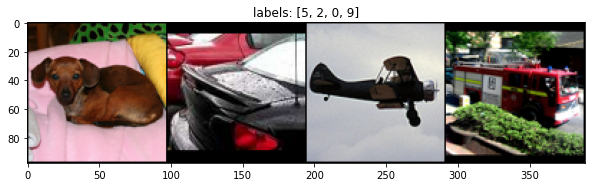

In [8]:
# show a few sample images from train_ds.
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(0)

# define helper function
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))

    plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

# pick random samples
grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:', rnd_inds)

# create a grid from the sample images
x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10.0, 10.0))
show(x_grid, y_grid)


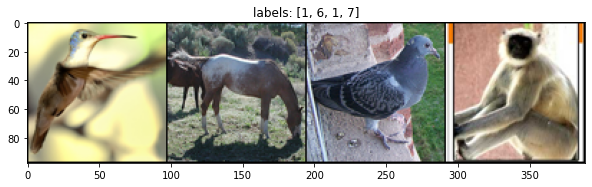

In [9]:
# sample images from val_ds
np.random.seed(0)

grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)

x_grid = [val_ds[i][0] for i in rnd_inds]
y_grid = [val_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=1)

plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [10]:
# calculate the mean and standard deviation of train_ds
import numpy as np

meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_ds]
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_ds]

meanR = np.mean([m[0] for m in meanRGB])
meanG = np.mean([m[1] for m in meanRGB])
meanB = np.mean([m[2] for m in meanRGB])

stdR = np.mean([s[0] for s in stdRGB])
stdG = np.mean([s[1] for s in stdRGB])
stdB = np.mean([s[2] for s in stdRGB])

print(meanR, meanG, meanB)
print(stdR, stdG, stdB)

0.4467106 0.43980986 0.40664646
0.22414584 0.22148906 0.22389975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [2732 2607 1653 3264]
torch.Size([3, 100, 394])


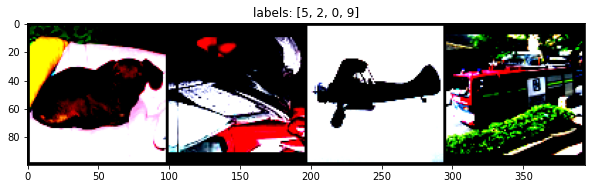

In [11]:
# define the image transformations for train_ds and test0_ds
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([meanR, meanG, meanB], [stdR, stdG, stdB])
])

train_ds.transform = train_transformer
test0_ds.transform = test0_transformer

# display the transformed sample images from train_ds
import torch
np.random.seed(0)
torch.manual_seed(0)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:', rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
print(x_grid.shape)

plt.figure(figsize=(10,10))
show(x_grid, y_grid)

In [12]:
# create dataloaders from train_ds and val_ds
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

# extract a batch from validation data
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])
torch.Size([64, 3, 96, 96])
torch.Size([64])


# 모델 구축하기

In [13]:
# load pre-trained model and visualize the convolutional layers in the first layer

# import resnet18 model with random weights
from torchvision import models
import torch

model_resnet18 = models.resnet18(pretrained=False)

print(model_resnet18)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# change the output layer to 10 classes
from torch import nn

num_classes = 10
num_ftrs = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda:0')
model_resnet18.to(device)

# get the model summary
from torchsummary import summary
summary(model_resnet18, input_size=(3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 7, 7])
0.0 1.1186091899871826
torch.Size([3, 65, 65])


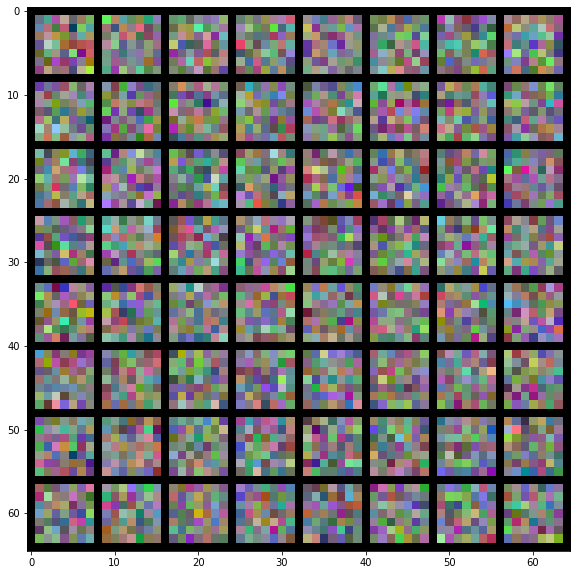

In [15]:
# visualize the filters of the first CNN layer
# get the weights of the first layer
for w in model_resnet18.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize the weights
min_w = torch.min(w)
w1 = (-1/(2*min_w))*w + 0.5
print(torch.min(w1).item(), torch.max(w1).item())

# make a grid and display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = utils.make_grid(x_grid, nrow=8, padding=1)
print(x_grid.shape)

plt.figure(figsize=(10, 10))
show(x_grid)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



torch.Size([64, 3, 7, 7])


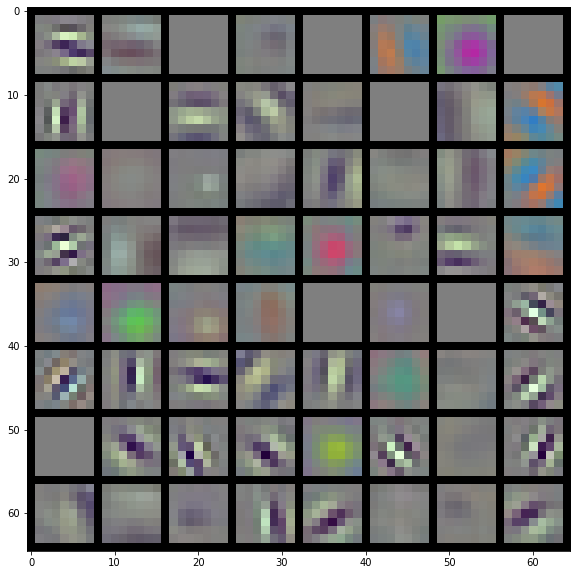

In [16]:
# load resnet18 with the pre-trained weights
from torchvision import models
import torch

resnet18_pretrained = models.resnet18(pretrained=True)

num_classes = 10
num_ftrs = resnet18_pretrained.fc.in_features
resnet18_pretrained.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('cuda:0')
resnet18_pretrained.to(device)

# visualize the filters of the first CNN layer
for w in resnet18_pretrained.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
show(x_grid)

# 손실 함수 정의하기

In [17]:
# define the loss function
loss_func = nn.CrossEntropyLoss(reduction='sum')

# see the loss in an example
torch.manual_seed(0)

n, c = 4, 5
y = torch.randn(n, c, requires_grad=True)
print(y.shape)

loss_func = nn.CrossEntropyLoss(reduction='sum')
target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y, target)
print(loss.item())

loss.backward()
print(y.data)

torch.Size([4, 5])
torch.Size([4])
7.312585353851318
tensor([[-1.1258, -1.1524, -0.2506, -0.4339,  0.5988],
        [-1.5551, -0.3414,  1.8530,  0.4681, -0.1577],
        [ 1.4437,  0.2660,  1.3894,  1.5863,  0.9463],
        [-0.8437,  0.9318,  1.2590,  2.0050,  0.0537]])


# optimizer 정의하기

In [18]:
# define the optimizer and the learning rate schedule
from torch import optim
opt = optim.Adam(model_resnet18.parameters(), lr=1e-4)

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
    
    current_lr = get_lr(opt)
    print('current lr={}'.format(current_lr))

# define a learning scheduler using the CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingLR
lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-05)

for i in range(10):
    lr_scheduler.step()
    print('epoch %s, lr: %.1e' %(i,get_lr(opt)))

epoch 0, lr: 5.5e-05
epoch 1, lr: 1.0e-05
epoch 2, lr: 5.5e-05
epoch 3, lr: 1.0e-04
epoch 4, lr: 5.5e-05
epoch 5, lr: 1.0e-05
epoch 6, lr: 5.5e-05
epoch 7, lr: 1.0e-04
epoch 8, lr: 5.5e-05
epoch 9, lr: 1.0e-05


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


# 전이 학습

In [19]:
# develop a helper function to count the number of correct predictions per data batch
def metrics_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# develop a helper function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metrics_batch(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# develop a helper function to compute the loss value and the performance metric for the entire dataset or an epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / float(len_data)
    metric = running_metric / float(len_data)
    return loss, metric

# develop the train_val function
def train_val(model, params):
    num_epochs = params['num_epochs']
    loss_func = params['loss_func']
    opt = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    sanity_check = params['sanity_check']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']

    loss_history = {
        'train': [],
        'val': [],
    }

    metric_history = {
        'train': [],
        'val': [],
    }

    # define variables to store the best model parameters
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
            loss_history['val'].append(val_loss)
            metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights')

        lr_scheduler.step()

        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    # return best model
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

Epoch 0/2, current lr=0.0001
Copied best model weights
train loss: 1.778423, dev loss: 1.600179, accuracy: 38.38
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights
train loss: 1.447631, dev loss: 1.479596, accuracy: 43.00
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights
train loss: 1.253337, dev loss: 1.361444, accuracy: 48.69
----------


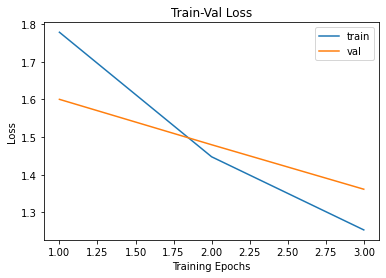

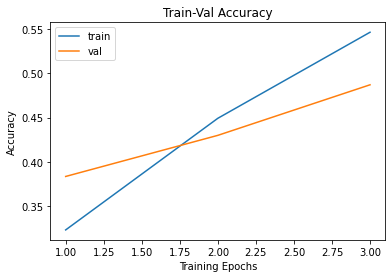

In [20]:
# train the model
# define the loss, optimizer, learning rate schedile
import copy

loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model_resnet18.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt, T_max=5, eta_min=1e-6)

# set the training parameters and call the train_val function
os.makedirs('/models', exist_ok=True)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "/models/resnet18.pt",
}

# train and validate the model
model_resnet18,loss_hist,metric_hist=train_val(model_resnet18,params_train)

# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [21]:
# train with pre-trained weights

import copy

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(resnet18_pretrained.parameters(), lr=1e-4)
lr_scheduler = CosineAnnealingLR(opt,T_max=5,eta_min=1e-6)

params_train={
 "num_epochs": 3,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "/models/resnet18_pretrained.pt",
}

# train and validate the model
resnet18_pretrained,loss_hist,metric_hist=train_val(resnet18_pretrained,params_train)

Epoch 0/2, current lr=0.0001
Copied best model weights
train loss: 0.903746, dev loss: 0.438118, accuracy: 85.12
----------
Epoch 1/2, current lr=9.05463412215599e-05
Copied best model weights
train loss: 0.433295, dev loss: 0.416979, accuracy: 84.56
----------
Epoch 2/2, current lr=6.57963412215599e-05
Copied best model weights
train loss: 0.275012, dev loss: 0.373974, accuracy: 87.25
----------


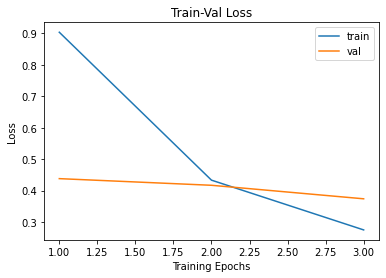

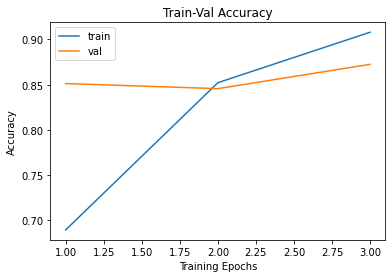

In [22]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# 모델 테스트

In [23]:
from torch import nn
from torchvision import models

# load model
model_resnet18 = models.resnet18(pretrained=False)
num_ftrs = model_resnet18.fc.in_features
# change last layer
num_classes=10
model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

In [24]:
import torch 

# load state_dict into model
path2weights="/models/resnet18_pretrained.pt"
model_resnet18.load_state_dict(torch.load(path2weights))


# set model in evaluation mode
model_resnet18.eval()


# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    model_resnet18=model_resnet18.to(device)

def deploy_model(model,dataset,device, num_classes=10,sanity_check=False):

    len_data=len(dataset)
    
    # initialize output tensor on CPU: due to GPU memory limits
    y_out=torch.zeros(len_data,num_classes)
    
    # initialize ground truth on CPU: due to GPU memory limits
    y_gt=np.zeros((len_data),dtype="uint8")
    
    # move model to device
    model=model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()    
            yy=model(x.unsqueeze(0).to(device))
            y_out[i]=torch.softmax(yy,dim=1)
            elapsed=time.time()-start
            elapsed_times.append(elapsed)

            if sanity_check is True:
                break

    inference_time=np.mean(elapsed_times)*1000
    print("average inference time per image on %s: %.2f ms " %(device,inference_time))
    return y_out.numpy(),y_gt

In [27]:
# deploy the model on the val/test dataset
import time
import numpy as np

y_out, y_gt = deploy_model(model_resnet18, val_ds, device=device, sanity_check=False)
print(y_out.shape, y_gt.shape)

from sklearn.metrics import accuracy_score

y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)

acc = accuracy_score(y_pred, y_gt)
print('val accuracy: %.2f' %acc)

y_out, y_gt = deploy_model(model_resnet18, test_ds, device=device)
y_pred = np.argmax(y_out, axis=1)
acc = accuracy_score(y_pred, y_gt)
print('test accuracy: %.2f' %acc)

average inference time per image on cuda: 3.19 ms 
(1600, 10) (1600,)
(1600,) (1600,)
val accuracy: 0.87
average inference time per image on cuda: 3.13 ms 
test accuracy: 0.88
